### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2024 Semester 2

## Assignment 3

**Student Name:**    `bichuan Liu`

**Student ID:**     `1520175`

## This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

## Estimating depth from Stereo

Standard imports

In [90]:
import numpy as np
from numpy import inf
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import math


A function to load an image file from the Middlebury dataset and downsample it by a factor of scale

In [91]:
def loadim(filename, scale):
    im = cv2.imread(filename)  # 使用OpenCV读取图像文件
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # 将图像从BGR颜色空间转换为RGB颜色空间（OpenCV默认是BGR）
    im = tf.cast(im, tf.float32)  # 将图像数据转换为TensorFlow中的float32类型
    shape = im.shape  # 获取图像的形状
    shape = [1, *shape]  # 将形状扩展为4维张量，形状为[1, 高度, 宽度, 通道]，以便与TensorFlow操作兼容
    im = tf.reshape(im, shape)  # 使用TensorFlow重塑图像为上述的4维张量形状
    im = tf.nn.avg_pool2d(input=im, ksize=(scale, scale), strides=(scale, scale), padding='VALID')  
    # 使用2D平均池化操作对图像进行下采样，ksize表示池化窗口大小为scale x scale，步长为scale，VALID表示无填充
    return im  # 返回下采样后的图像

A function to load a disparity file from the Middlebury dataset and downsample it by a factor of scale

This function also modifies the offsets in the tensor by a factor of scale so that it is consistent with images at that scale

In [92]:
def loaddisparity(filename, scale):
    disp = cv2.imread(filename, cv2.IMREAD_UNCHANGED)  # 使用OpenCV读取文件，不改变图像深度或通道数（IMREAD_UNCHANGED）
    
    with Path(filename).open('rb') as pfm_file:  # 以二进制方式打开文件
        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))  
        # 读取PFM文件的前三行内容并解码为字符串
    fscale = abs(float(line3))  # 将第三行转换为浮点数，表示视差图的缩放因子
    
    # 清理图像并重新缩放
    disp[disp == inf] = 0  # 将视差图中无穷大的像素值设为0
    shape = disp.shape  # 获取视差图的形状
    shape = [1, *shape, 1]  # 将形状扩展为4维张量，形状为[1, 高度, 宽度, 通道]，适用于TensorFlow操作
    disp = tf.reshape(disp, shape)  # 使用TensorFlow重塑视差图为上述的4维张量形状
    disp = tf.nn.max_pool2d(input=disp, ksize=(scale, scale), strides=(scale, scale), padding='VALID')  
    # 使用2D最大池化操作对视差图进行下采样，ksize表示池化窗口大小为scale x scale，步长为scale，VALID表示无填充
    disp = disp * fscale / scale  # 根据缩放因子fscale重新缩放视差图，调整视差图的精度
    return disp  # 返回处理后的视差图

select a directory from the Middlebury dataset containing an image pair and corresponding disparities

The images are big (2016 high and 2940 wide) - so choose a scale to downsample them to more manageable size

Specify the size of window to use for matching

In [93]:
filepath = 'Middlebury/Backpack-perfect'  # 选择要处理的一对立体图像，文件路径指向Middlebury数据集中背包的立体图像对

scale = 4  # 缩放因子，将图像缩小4倍，以减少计算量并加快处理速度

halfwin = 2  # 匹配窗口大小。`halfwin`表示每个匹配窗口中，中心像素两侧各包含2个像素。即实际窗口大小为 (2 * halfwin + 1) = 5 像素

Load two images and two disparities

In [94]:
im0 = loadim(filepath + '/im0.png', scale)  # 加载左视图图像（im0.png），并按指定的scale缩放
im1 = loadim(filepath + '/im1.png', scale)  # 加载右视图图像（im1.png），并按指定的scale缩放
disp0 = loaddisparity(filepath + '/disp0.pfm', scale)  # 加载左视图的视差图（disp0.pfm），并按指定的scale进行下采样
disp1 = loaddisparity(filepath + '/disp1.pfm', scale)  # 加载右视图的视差图（disp1.pfm），并按指定的scale进行下采样

Display them

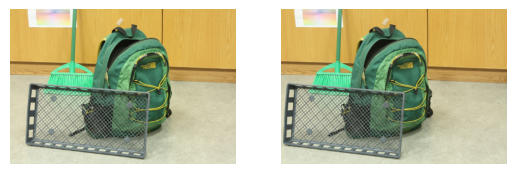

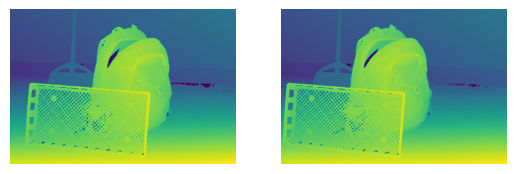

In [95]:
f, axarr = plt.subplots(1, 2)  # 创建一个包含1行2列子图的图像画布，用于显示左右图像
axarr[0].imshow(tf.cast(im0[0], tf.uint8).numpy())  # 将im0的第一个图像转换为uint8格式后显示
axarr[0].set_axis_off()  # 隐藏第一个子图的坐标轴
axarr[1].imshow(tf.cast(im1[0], tf.uint8).numpy())  # 将im1的第一个图像转换为uint8格式后显示
axarr[1].set_axis_off()  # 隐藏第二个子图的坐标轴

f, axarr = plt.subplots(1, 2)  # 创建另一个包含1行2列子图的图像画布，用于显示左右视差图
axarr[0].imshow(disp0[0])  # 显示左视图的视差图disp0
axarr[0].set_axis_off()  # 隐藏第一个子图的坐标轴
axarr[1].imshow(disp1[0])  # 显示右视图的视差图disp1
axarr[1].set_axis_off()  # 隐藏第二个子图的坐标轴

## Image warping

Use the ground truth disparity map to warp im0 to move the pixels to where they should be for im1

NB: this is very slow because we're workign one pixel at a time. At scale=8 this cell takes 15s on my M1 macbook air.

If you get worried that this is not working, try printing out i each time a row changes to monitor it

In [96]:
scale=8

In [97]:
# if scale > 7:  # 当缩放因子大于7时执行下面的代码
#     remapped = np.zeros(im0.shape)  # 创建一个与im0形状相同的全零数组，用于存放重新映射后的图像
#     b, rows, cols, _ = im0.shape  # 获取im0的形状，分别代表批量大小（b）、图像的行数（rows）、列数（cols）和通道数（_）
    
#     for i in range(rows):  # 遍历每一行
#         for j in range(cols):  # 遍历每一列
#             offset = disp0[0, i, j, 0]  # 从视差图disp0中获取对应位置的视差值
#             joff = int(j - offset)  # 计算右视图中对应像素的列索引，基于视差进行水平位移
            
#             if offset > 0 and joff >= 0 and joff < cols:  # 如果视差有效，且映射后的列索引在图像的有效范围内
#                 remapped[0, i, joff, :] = im0[0, i, j, :]  # 将左视图中当前像素的值映射到右视图对应位置

Display the im0->im1 warped image alongside im1 for comparison

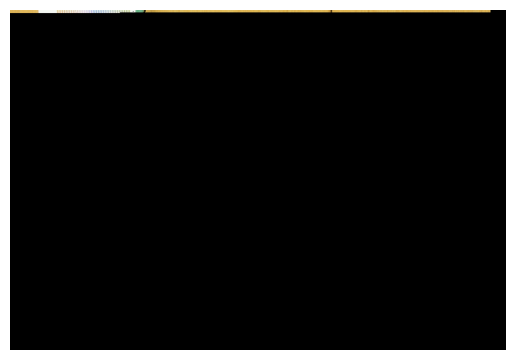

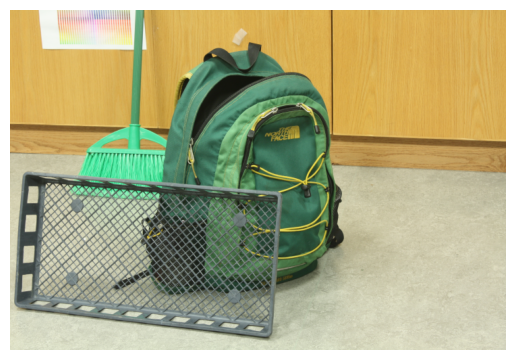

In [98]:
if scale > 7:
    plt.figure(0)
    fig=plt.imshow(tf.cast(remapped[0],tf.uint8).numpy())
    fig.axes.set_axis_off()
    plt.figure(1)
    fig=plt.imshow(tf.cast(im1[0],tf.uint8).numpy())
    fig.axes.set_axis_off()

## Compute Disparity

Conduct a sweep over offets computing the squared error at each pixel between im1 and a shifted im0

In [99]:
# cheat a bit so that we're only considering disparities up to the maximum disparity in the ground truth
# 偏移量扫描
maxoffset = math.ceil(float(tf.math.reduce_max(disp0)))  # 获取视差图disp0中的最大视差值，向上取整作为最大偏移量

b, rows, cols, _ = im0.shape  # 获取左视图im0的形状（批次大小、行数、列数和通道数）
diffsumsq = []  # 创建一个空列表，用于存储每个偏移量下的误差平方和

# 平方误差计算
# scan over the offset range we're interested in
for offset in range(maxoffset):  # 遍历从0到最大视差值maxoffset的偏移范围
    # shift im0 by offset and compute the difference to im1
    diff = im1[0, :, 0:cols-maxoffset, :] - im0[0, :, offset:cols-maxoffset+offset, :]  
    # 将左视图im0向右平移offset个像素，并计算与右视图im1的像素差值
    
    # square the errors
    diffsq = diff * diff  # 对像素差值取平方
    
    # sum over r,g,b errors and stack the error images into a list
    diffsumsq.append(tf.math.reduce_sum(diffsq, axis=-1, keepdims=True))  
    # 对RGB通道的误差进行求和，结果保留在最后一个维度中，并将每个偏移下的误差和存入列表diffsumsq

# 存储每个偏移量的误差
# turn the list of error images into a tensor - batch dimension scans over the offsets
diffsumsq = tf.stack(diffsumsq)  # 将误差列表转换为TensorFlow张量，张量的批量维度扫描不同的偏移量

Make a kernel to add up the squared errors within a window

In [100]:
windowsize = 2 * halfwin + 1  # 计算窗口大小，窗口的宽和高等于 (2 * halfwin + 1)
                              # 其中 halfwin 表示中心像素两侧的像素数，窗口的总大小是包含中心像素在内的尺寸

kshape = [windowsize, windowsize, 1, 1]  # 定义卷积核的形状，卷积核的大小为窗口大小，最后两个1分别表示输入和输出的通道数

kernel = np.ones(kshape)  # 创建一个全1的卷积核，形状为 kshape

Convolve the kernel with the stack of squared error images to get the squared error within each window at each offset

In [101]:
# 窗口加权
windowdiffsumsq = tf.nn.conv2d(diffsumsq, kernel, strides=1, padding='VALID')  # 计算误差平方和的窗口加权总和

sample the offsets and display the sum squared error within each window at each offset

Features should disappear at the correct disparity

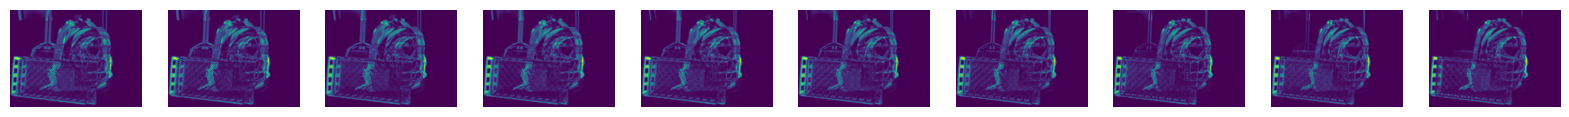

In [102]:
f, axarr = plt.subplots(1, 10, figsize=(20, 16))  # 创建一个包含1行10列子图的图像画布，图像大小为20x16英寸
for i in range(10):  # 遍历前10个偏移量的窗口误差平方和
    axarr[i].imshow(windowdiffsumsq[i * 2])  # 显示每隔2个偏移量的误差平方和图像
    axarr[i].set_axis_off()  # 隐藏坐标轴，使图像显示得更加清晰

Find the best disparirty for each pixel by finding the position of the minimum error using argmin

In [103]:
bestoffset = tf.math.argmin(windowdiffsumsq, axis=0)  # 找到误差平方和最小的偏移量
bestoffset = tf.cast(bestoffset, tf.float32)  # 将结果转换为浮点数类型

Choose the part of the ground truth disparity image that corresponds to the one we have computed taking into account pixels lost due to windowing and from the disparity sweep

In [104]:
outr, outc, _ = bestoffset.shape  # 获取bestoffset的形状，分别是行数(outr)、列数(outc)和通道数(这里通道数通常为1)

gt = disp0[0, halfwin:halfwin+outr, halfwin:halfwin+outc, :]  # 提取视差图disp0的部分区域，与bestoffset对齐

Display our computed disparity and the ground truth disparity

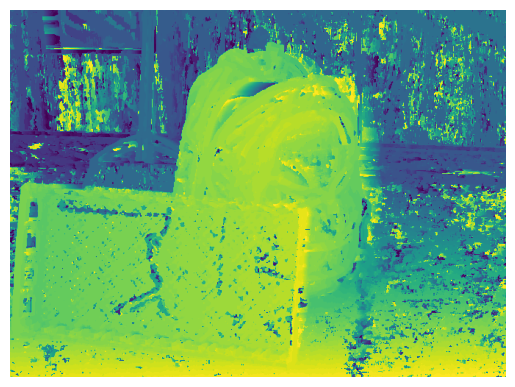

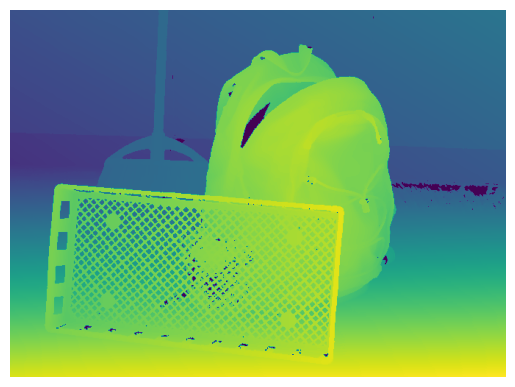

In [105]:
plt.figure(0)  # 创建一个新的图像窗口，编号为0
fig = plt.imshow(bestoffset)  # 显示最佳视差偏移量图（bestoffset）
fig.axes.set_axis_off()  # 隐藏坐标轴，使图像显示得更加清晰
plt.figure(1)  # 创建另一个新的图像窗口，编号为1
fig = plt.imshow(gt)  # 显示地面真值视差图（ground truth，gt）
fig.axes.set_axis_off()  # 隐藏坐标轴，使图像显示得更加清晰

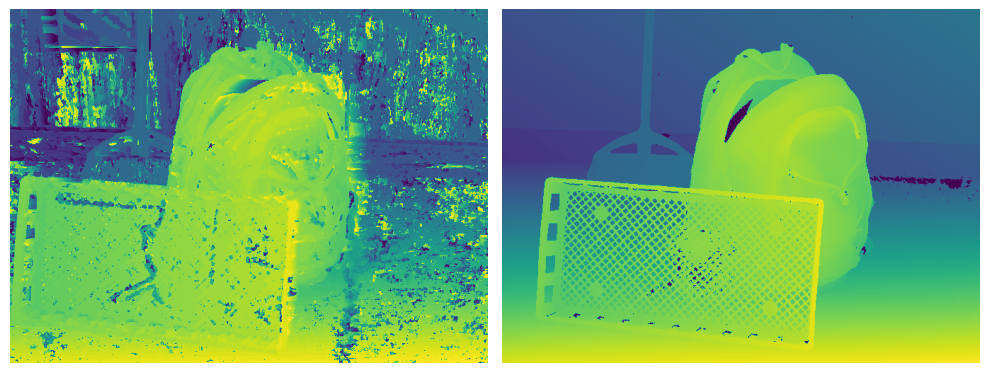

In [106]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))  # 创建1行2列的子图画布，图像大小为10x5英寸
axarr[0].imshow(bestoffset)  # 在左边显示最佳视差偏移量图
axarr[0].set_axis_off()  # 隐藏左边图的坐标轴

axarr[1].imshow(gt)  # 在右边显示地面真值视差图
axarr[1].set_axis_off()  # 隐藏右边图的坐标轴

plt.tight_layout()  # 自动调整子图布局
plt.show()  # 显示图像


Calculate how well we did.  Count the number of pixels for which we have a ground truth disparity that are within a disparity error of 2.5 pixels of the ground truth and report as an accuracy percentage

In [107]:
disperror = tf.math.abs(bestoffset - gt)  # 计算预测的视差值（bestoffset）与地面真值（gt）之间的绝对误差

could = gt != 0  # 创建掩码，找出地面真值不为0的像素点（有效的像素点）

good = tf.logical_and(could, disperror < 2.5)  # 找出误差小于2.5像素且地面真值有效的像素点，生成一个布尔掩码

numgood = (int(tf.math.count_nonzero(good)))  # 计算满足误差小于2.5像素的像素点数量
numcould = (int(tf.math.count_nonzero(could)))  # 计算所有有效地面真值像素点的数量

print(numgood, ' out of ', numcould, ' pixels = ', 100 * numgood / numcould, '%')  # 打印准确率

189005  out of  335053  pixels =  56.41047834223242 %


## task2

In [108]:
def disparity_estimation(im0, im1, disp0, kernel, scales, halfwin_values):
    # 循环遍历不同 scale 和 halfwin 参数
    for scale in scales:
        for halfwin in halfwin_values:
            print(f'Running for scale={scale}, halfwin={halfwin}')
           
            # 视差估计过程，扫描不同的偏移量
            maxoffset = math.ceil(float(tf.math.reduce_max(disp0)))  # 最大视差
            b, rows, cols, _ = im0.shape
            diffsumsq = []

            for offset in range(maxoffset):
                diff = im1[0, :, 0:cols-maxoffset, :] - im0[0, :, offset:cols-maxoffset+offset, :]
                diffsq = diff * diff
                diffsumsq.append(tf.math.reduce_sum(diffsq, axis=-1, keepdims=True))
            
            diffsumsq = tf.stack(diffsumsq)  # 堆叠误差
            
            # 窗口加权
            windowdiffsumsq = tf.nn.conv2d(diffsumsq, kernel, strides=1, padding='VALID')
            
            # 寻找误差最小的偏移量
            bestoffset = tf.math.argmin(windowdiffsumsq, axis=0)
            bestoffset = tf.cast(bestoffset, tf.float32)

            # 提取地面真值视差与估计结果对齐
            outr, outc, _ = bestoffset.shape
            gt = disp0[0, halfwin:halfwin+outr, halfwin:halfwin+outc, :]
            
            # 计算视差误差
            disperror = tf.math.abs(bestoffset - gt)
            could = gt != 0  # 有效像素
            good = tf.logical_and(could, disperror < 2.5)
            
            numgood = int(tf.math.count_nonzero(good))
            numcould = int(tf.math.count_nonzero(could))
            accuracy = 100 * numgood / numcould
            
            print(f'Scale: {scale}, Halfwin: {halfwin}, Accuracy: {accuracy:.2f}%')
            
            # 可视化结果
            fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
            axarr[0].imshow(bestoffset)  # 显示估计的视差图
            axarr[0].set_axis_off()
            axarr[0].set_title(f'Estimated Disparity (scale={scale}, halfwin={halfwin})')
            
            axarr[1].imshow(gt)  # 显示地面真值视差图
            axarr[1].set_axis_off()
            axarr[1].set_title('Ground Truth Disparity')
            
            plt.tight_layout()
            plt.show()

In [109]:
# 设置不同的 scale 和 halfwin 参数组合
scales = [4, 2]
halfwin_values = [1, 2, 3, 4]  # 选择不同的窗口大小

In [110]:
# 计算窗口大小
windowsize = 2 * halfwin + 1
kshape = [windowsize, windowsize, 1, 1]  # 创建卷积核形状
kernel = np.ones(kshape)  # 创建一个全1的卷积核

In [111]:
filepath = 'Middlebury/Backpack-perfect'
# 加载图像和视差图，按照不同 scale 进行缩放
im0 = loadim(filepath + '/im0.png', scale)
im1 = loadim(filepath + '/im1.png', scale)
disp0 = loaddisparity(filepath + '/disp0.pfm', scale)

Running for scale=4, halfwin=1
Scale: 4, Halfwin: 1, Accuracy: 69.03%


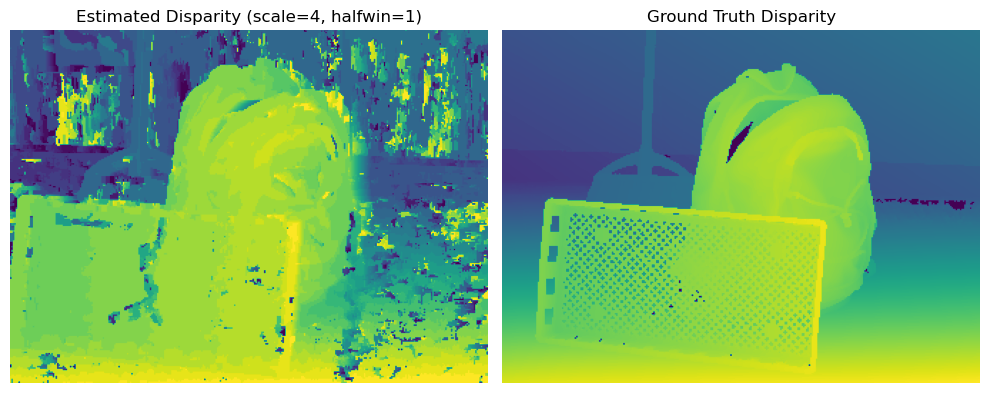

Running for scale=4, halfwin=2
Scale: 4, Halfwin: 2, Accuracy: 69.64%


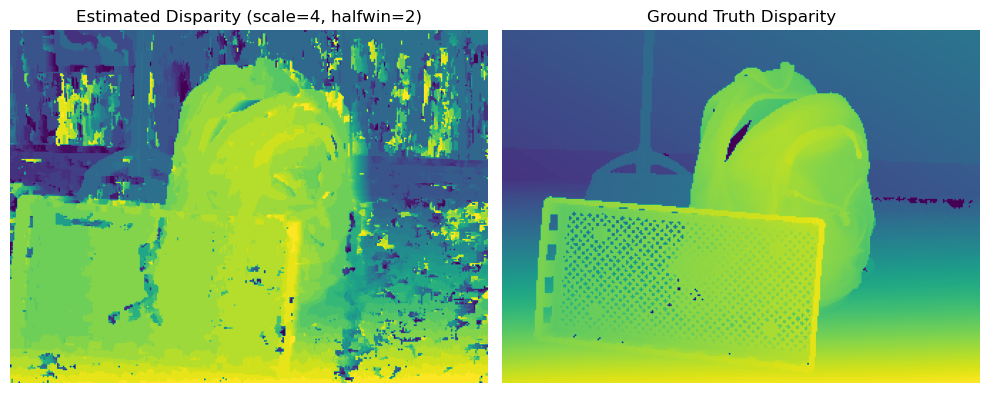

Running for scale=4, halfwin=3
Scale: 4, Halfwin: 3, Accuracy: 70.20%


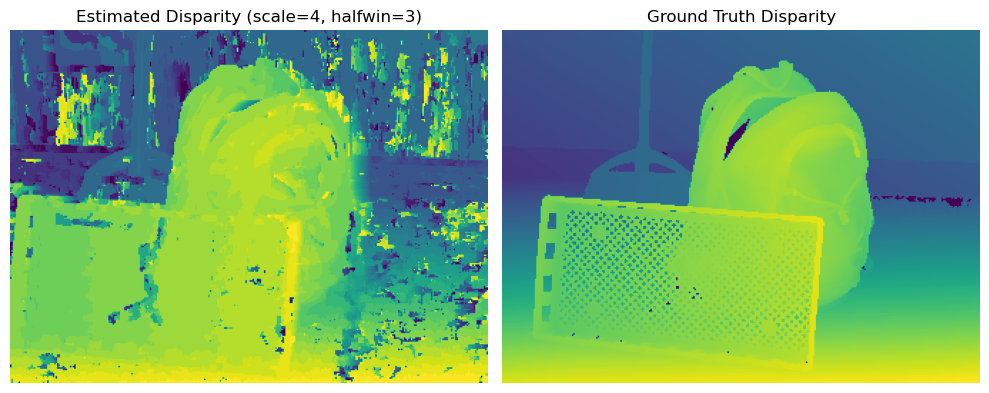

Running for scale=4, halfwin=4
Scale: 4, Halfwin: 4, Accuracy: 70.76%


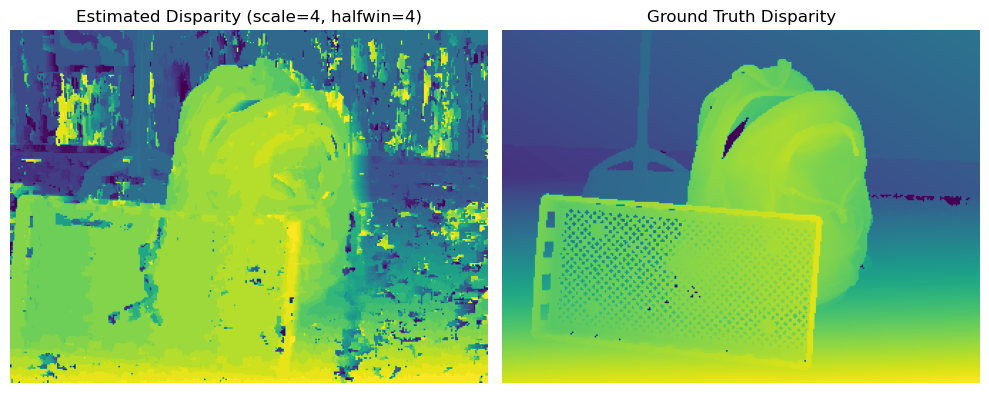

Running for scale=2, halfwin=1
Scale: 2, Halfwin: 1, Accuracy: 69.03%


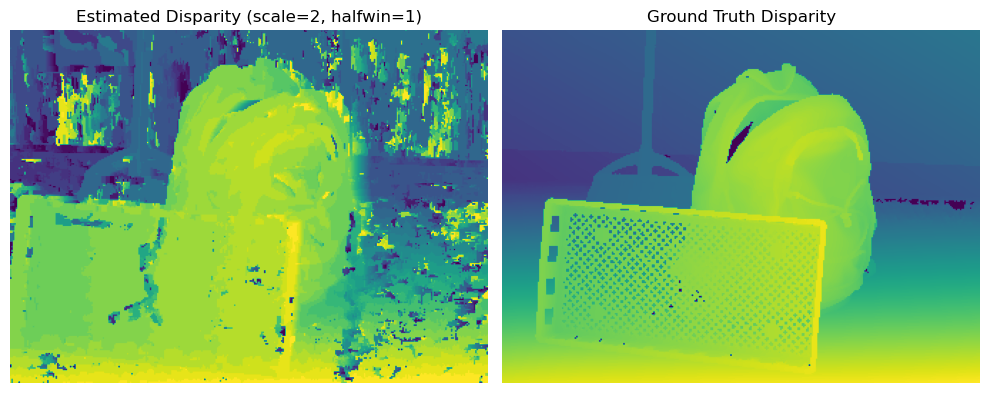

Running for scale=2, halfwin=2
Scale: 2, Halfwin: 2, Accuracy: 69.64%


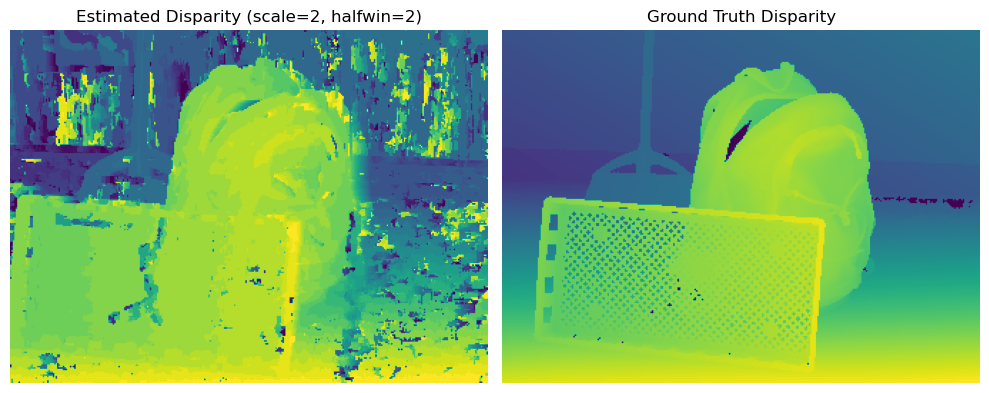

Running for scale=2, halfwin=3
Scale: 2, Halfwin: 3, Accuracy: 70.20%


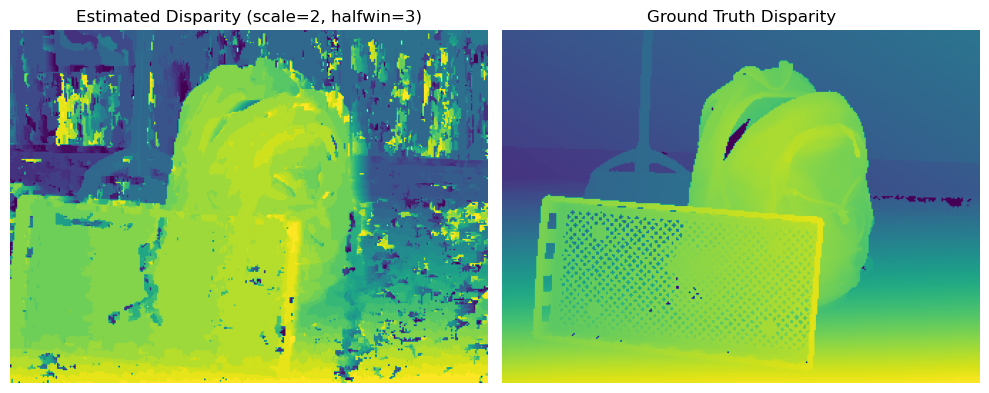

Running for scale=2, halfwin=4
Scale: 2, Halfwin: 4, Accuracy: 70.76%


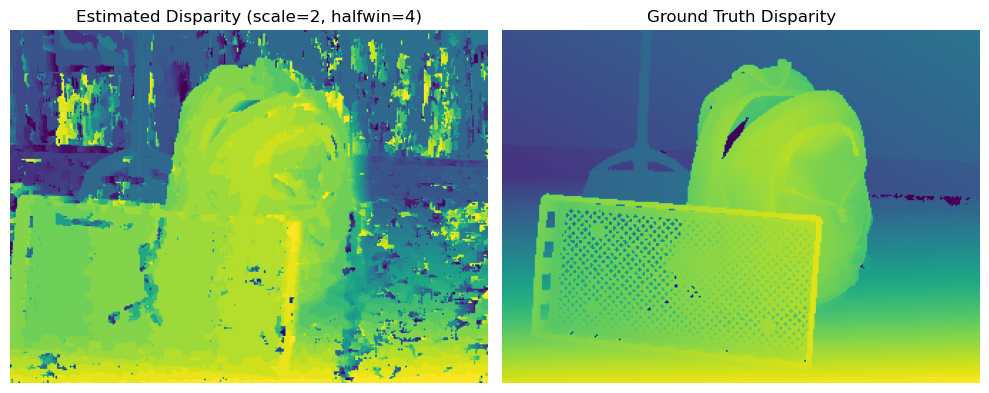

In [112]:
# 调用 disparity_estimation 函数
disparity_estimation(im0, im1, disp0, kernel, scales, halfwin_values)

## task 3

In [113]:
# 创建高斯加权卷积核
def create_gaussian_kernel2(windowsize, sigma):
    ax = np.linspace(-(windowsize // 2), windowsize // 2, windowsize)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)  # 归一化
    return kernel[:, :, None, None]

In [114]:
# 创建高斯加权卷积核，基于图片中的方法
def create_gaussian_kernel(halfwin):
    windowsize = 2 * halfwin + 1
    sigma = halfwin / 2.0

    # 生成一维高斯核并扩展为二维高斯核
    gauss_1d = cv2.getGaussianKernel(windowsize, sigma)
    gauss_2d = gauss_1d @ gauss_1d.T  # 二维高斯核

    # 扩展为四维高斯核 (height, width, in_channels, out_channels)
    gaussian_kernel_4d = gauss_2d[:, :, np.newaxis, np.newaxis]
    
    return gaussian_kernel_4d

In [115]:
# 设置不同的 scale 和 halfwin 参数
scales = [4, 2]
halfwin_values = [1, 2, 3, 4]  # 尝试不同的窗口大小

In [116]:
# 加载图像和视差图，按照不同 scale 进行缩放
im0 = loadim(filepath + '/im0.png', scale)
im1 = loadim(filepath + '/im1.png', scale)
disp0 = loaddisparity(filepath + '/disp0.pfm', scale)

In [117]:
# # 计算窗口大小
# windowsize = 2 * halfwin + 1
# sigma = windowsize / 4  # 根据任务要求，sigma 是窗口大小的四分之一
# gaussian_kernel = create_gaussian_kernel2(windowsize, sigma)  # 创建高斯加权卷积核
# # 调用 disparity_estimation 函数
# disparity_estimation(im0, im1, disp0, gaussian_kernel, scales, halfwin_values)

Running for scale=4, halfwin=1
Scale: 4, Halfwin: 1, Accuracy: 63.44%


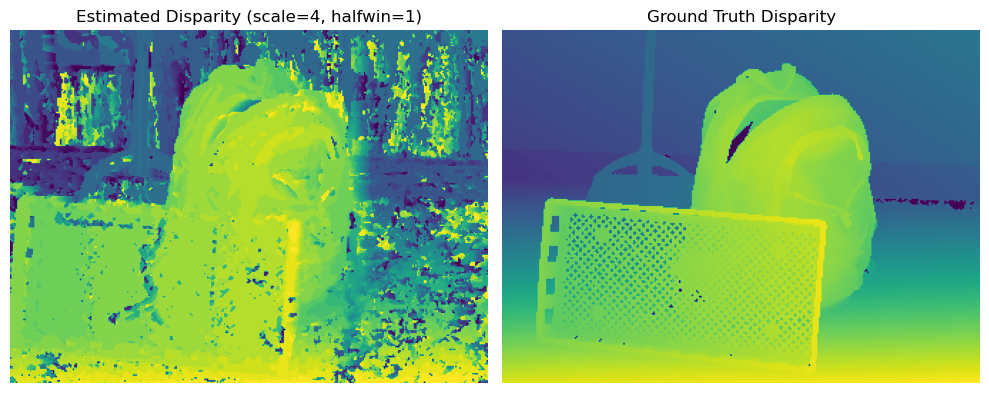

Running for scale=4, halfwin=2
Scale: 4, Halfwin: 2, Accuracy: 63.93%


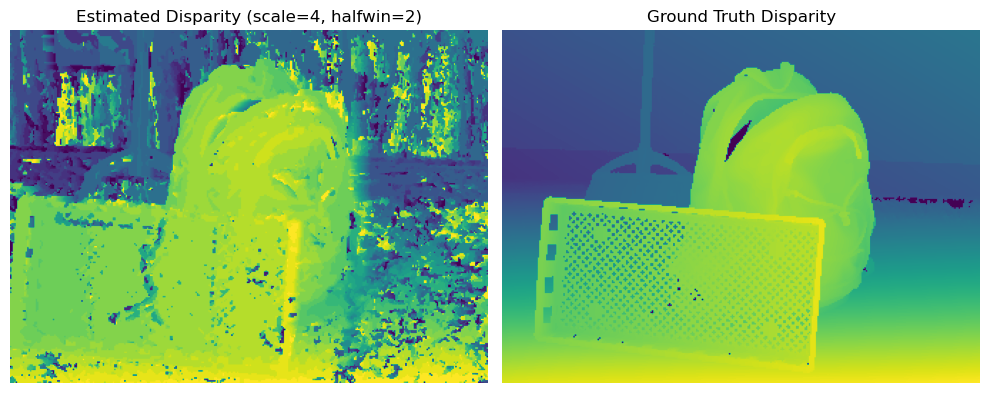

Running for scale=4, halfwin=3
Scale: 4, Halfwin: 3, Accuracy: 64.49%


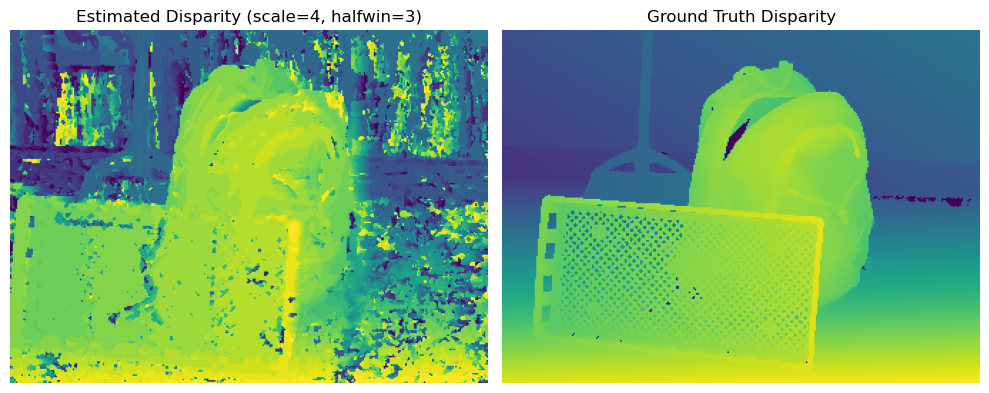

Running for scale=4, halfwin=4
Scale: 4, Halfwin: 4, Accuracy: 64.99%


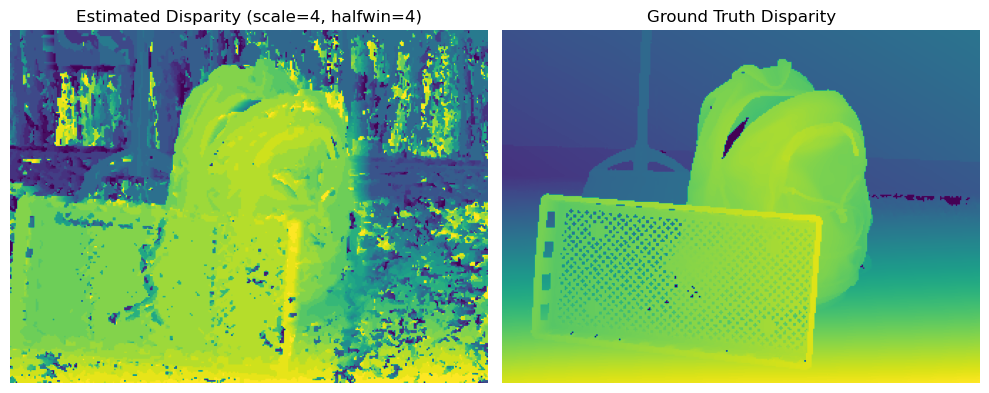

Running for scale=2, halfwin=1
Scale: 2, Halfwin: 1, Accuracy: 63.44%


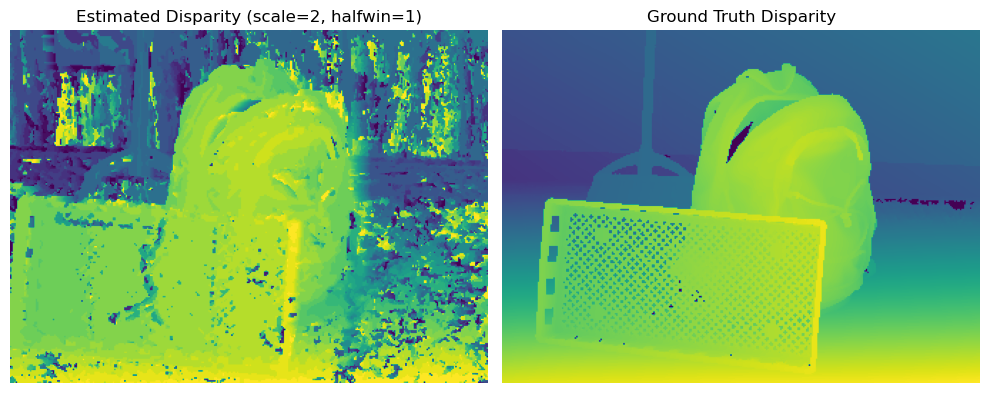

Running for scale=2, halfwin=2
Scale: 2, Halfwin: 2, Accuracy: 63.93%


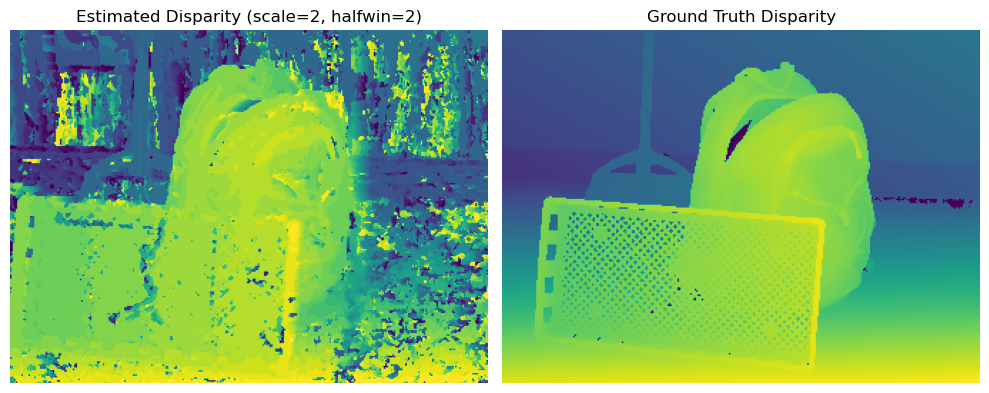

Running for scale=2, halfwin=3
Scale: 2, Halfwin: 3, Accuracy: 64.49%


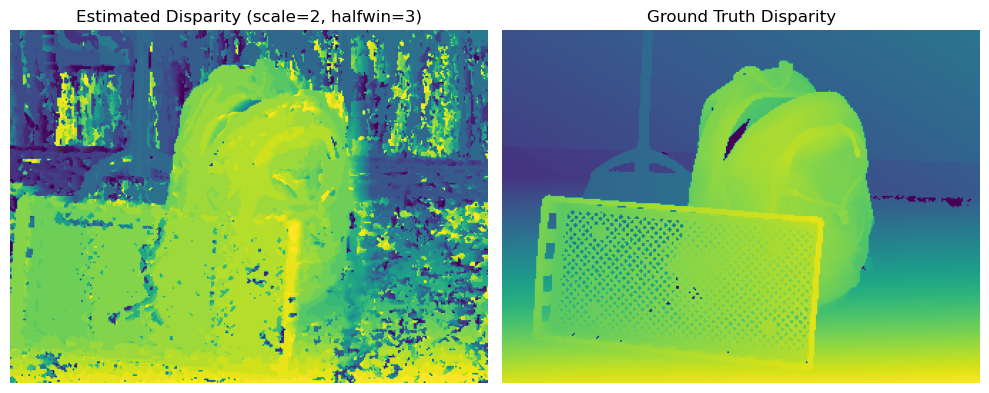

Running for scale=2, halfwin=4
Scale: 2, Halfwin: 4, Accuracy: 64.99%


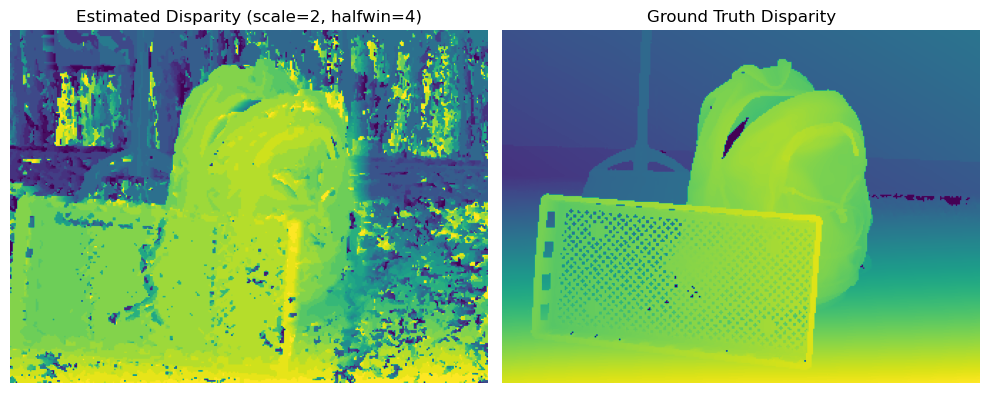

In [118]:
gaussian_kernel = create_gaussian_kernel(halfwin)
# 调用 disparity_estimation 函数
disparity_estimation(im0, im1, disp0, gaussian_kernel, scales, halfwin_values)